# Time Series Forecasting Using LSTM Model

In [1]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ---------------------------
# Reproducibility
# ---------------------------
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(42)

In [3]:
# Define file path
file_path = "/Users/elbethelzewdie/Downloads/portfolio-optimization/portfolio-optimization/data/raw/financial_data.csv"

# Load CSV into DataFrame
df = pd.read_csv(file_path, parse_dates=["Date"])

In [4]:
# ---------------------------
# Data preparation
# ---------------------------
tesla_df = df[df["Ticker"] == "TSLA"].copy()
tesla_df = tesla_df.sort_values("Date").reset_index(drop=True)

series = tesla_df.set_index("Date")["Close"].astype(float)
returns = series.pct_change().dropna()

WINDOW_SIZE = 60
split_date = pd.Timestamp("2025-01-01")

train = returns[returns.index < split_date]
test  = returns[returns.index >= split_date]

print(f"Train samples: {len(train)}, Test samples: {len(test)}")

Train samples: 2515, Test samples: 259


In [5]:
# ---------------------------
# Scaling (train ONLY)
# ---------------------------
scaler = MinMaxScaler(feature_range=(-1, 1))

train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
test_scaled  = scaler.transform(test.values.reshape(-1, 1))

In [6]:
# ---------------------------
# Sequence creation
# ---------------------------
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)
X_test,  y_test  = create_sequences(test_scaled,  WINDOW_SIZE)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0],  X_test.shape[1],  1)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


X_train: (2455, 60, 1) X_test: (199, 60, 1)


In [7]:
# ---------------------------
# Model
# ---------------------------
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, 1)),
    LSTM(32),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ---------------------------
# Training
# ---------------------------
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
]

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0280 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0279 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0279 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0279 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0279 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0279 - val_loss: 0.0351 - learning_rate: 0.0010
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0278 - val_loss: 0.0352 - learning_rate: 5.0000e-04
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0278 - val_loss: 0.0351 - learning_rate: 5.0000e-04
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0278 - val_loss: 0.0351 - learning_rate: 5.0000e-0

In [9]:
# ---------------------------
# Predict returns
# ---------------------------
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [10]:
# ---------------------------
# Reconstruct prices
# ---------------------------
last_train_price = series.loc[train.index[-1]]
price_forecast = []

current_price = last_train_price
for r in y_pred:
    current_price *= (1 + r)
    price_forecast.append(current_price)

price_forecast = pd.Series(
    price_forecast,
    index=test.index[WINDOW_SIZE:]
)

actual_price = series.loc[price_forecast.index]

In [11]:
# ---------------------------
# Evaluation
# ---------------------------
mae = mean_absolute_error(actual_price, price_forecast)
rmse = np.sqrt(mean_squared_error(actual_price, price_forecast))
mape = np.mean(np.abs((actual_price - price_forecast) / actual_price)) * 100

print("\nForecast Evaluation Metrics:")
print(f"  MAE  : ${mae:.2f}")
print(f"  RMSE : ${rmse:.2f}")
print(f"  MAPE : {mape:.2f}%")


Forecast Evaluation Metrics:
  MAE  : $166.14
  RMSE : $169.82
  MAPE : 46.73%


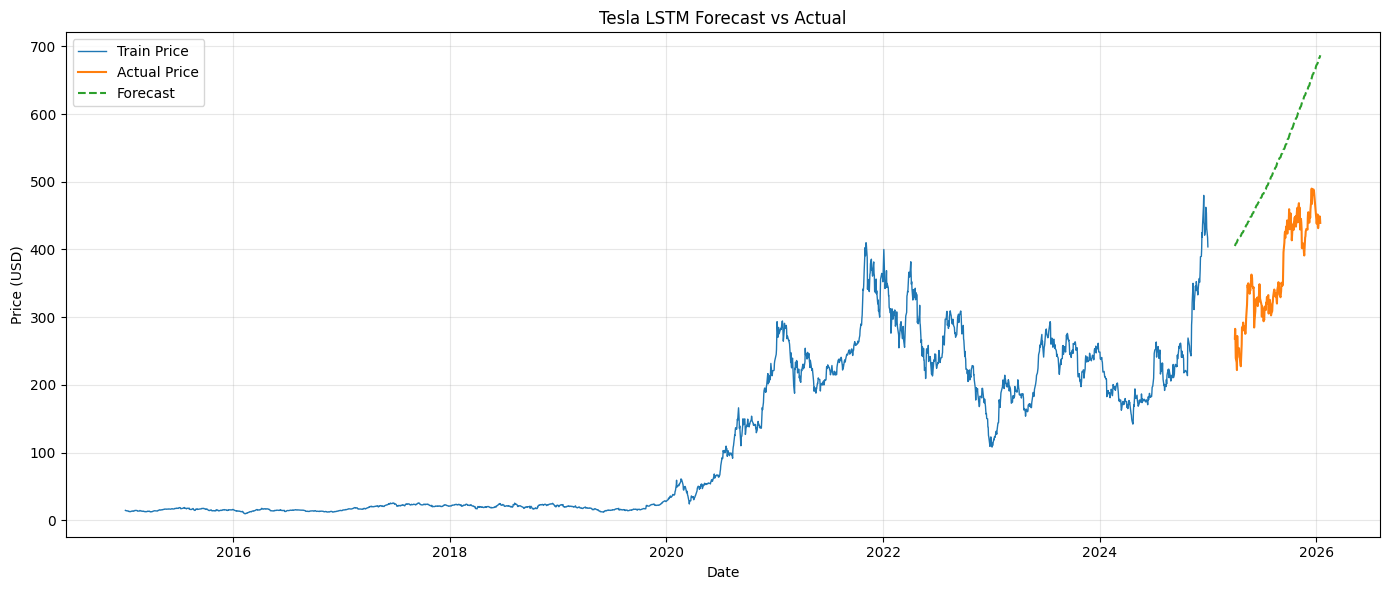

In [12]:
# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(14,6))

plt.plot(series.loc[:train.index[-1]], label="Train Price", linewidth=1)
plt.plot(actual_price, label="Actual Price", linewidth=1.5)
plt.plot(price_forecast, label="Forecast", linestyle="--", linewidth=1.5)

plt.title("Tesla LSTM Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [25]:
model.save("lstm_baseline_best_test.keras")


In [13]:
val_size = int(len(X_train) * 0.1)

X_tr, X_val = X_train[:-val_size], X_train[-val_size:]
y_tr, y_val = y_train[:-val_size], y_train[-val_size:]

print(X_tr.shape, X_val.shape)

(2210, 60, 1) (245, 60, 1)


In [14]:
from tensorflow.keras.losses import Huber

def build_lstm_model(layers, input_shape, lr):
    model = Sequential()
    
    for i, units in enumerate(layers):
        model.add(
            LSTM(
                units,
                return_sequences=(i < len(layers) - 1),
                input_shape=input_shape if i == 0 else None
            )
        )
    
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=Huber()
    )
    
    return model

In [15]:
param_grid = {
    "layers": [
        [64],
        [64, 32],
        [128, 64]
    ],
    "learning_rate": [1e-3, 5e-4],
    "batch_size": [16, 32],
    "epochs": [50]
}


In [16]:
results = []

for layers in param_grid["layers"]:
    for lr in param_grid["learning_rate"]:
        for batch in param_grid["batch_size"]:
            
            print(f"Running: layers={layers}, lr={lr}, batch={batch}")
            
            model = build_lstm_model(
                layers=layers,
                input_shape=(WINDOW_SIZE, X_train.shape[2]),
                lr=lr
            )
            
            early_stop = EarlyStopping(
                monitor="val_loss",
                patience=10,
                restore_best_weights=True
            )
            
            history = model.fit(
                X_tr,
                y_tr,
                epochs=param_grid["epochs"][0],
                batch_size=batch,
                validation_data=(X_val, y_val),
                callbacks=[early_stop],
                verbose=0
            )
            
            val_loss = min(history.history["val_loss"])
            
            y_val_pred = model.predict(X_val, verbose=0)
            val_mae = np.mean(np.abs(y_val - y_val_pred))
            
            results.append({
                "layers": str(layers),
                "learning_rate": lr,
                "batch_size": batch,
                "val_loss": val_loss,
                "val_mae": val_mae
            })


Running: layers=[64], lr=0.001, batch=16
Running: layers=[64], lr=0.001, batch=32
Running: layers=[64], lr=0.0005, batch=16
Running: layers=[64], lr=0.0005, batch=32
Running: layers=[64, 32], lr=0.001, batch=16
Running: layers=[64, 32], lr=0.001, batch=32
Running: layers=[64, 32], lr=0.0005, batch=16
Running: layers=[64, 32], lr=0.0005, batch=32
Running: layers=[128, 64], lr=0.001, batch=16
Running: layers=[128, 64], lr=0.001, batch=32
Running: layers=[128, 64], lr=0.0005, batch=16
Running: layers=[128, 64], lr=0.0005, batch=32


In [17]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("val_loss")

results_df

,layers,learning_rate,batch_size,val_loss,val_mae
8,"[128, 64]",0.0010,16,0.017524,0.135675
5,"[64, 32]",0.0010,32,0.017592,0.135406
11,"[128, 64]",0.0005,32,0.017604,0.135331
7,"[64, 32]",0.0005,32,0.017611,0.135429
9,"[128, 64]",0.0010,32,0.017613,0.135111
2,[64],0.0005,16,0.017617,0.135308
10,"[128, 64]",0.0005,16,0.017617,0.135156
1,[64],0.0010,32,0.017618,0.135409
4,"[64, 32]",0.0010,16,0.017618,0.135216
6,"[64, 32]",0.0005,16,0.017620,0.135228


In [18]:
best = results_df.iloc[0]
print("Best configuration:")
print(best)

Best configuration:
layers           [128, 64]
learning_rate        0.001
batch_size              16
val_loss          0.017524
val_mae           0.135675
Name: 8, dtype: object


In [19]:
best_layers = eval(best["layers"])
best_lr = best["learning_rate"]
best_batch = best["batch_size"]

final_model = build_lstm_model(
    layers=best_layers,
    input_shape=(WINDOW_SIZE, X_train.shape[2]),
    lr=best_lr
)

final_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=best_batch,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)


Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0143
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0143
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0143
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 0.0143
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0143
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 0.0143
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0143
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0143
Epoch 9/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0143
Epoch 10/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0143
Epoch 11/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0143
Epoch 12/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0143
Epoch 13/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - loss: 0.0143
Epoch 14/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 0.0142
Epoch 15/100
154/154 ━━━━━━━━

In [20]:
# ---------------------------
# Predict returns
# ---------------------------
y_pred_new = final_model.predict(X_test)
y_pred_final = scaler.inverse_transform(y_pred_new).flatten()


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step


In [22]:
# ---------------------------
# Reconstruct prices
# ---------------------------
last_train_price = series.loc[train.index[-1]]
price_forecast = []

current_price = last_train_price
for r in y_pred_final:
    current_price *= (1 + r)
    price_forecast.append(current_price)

price_forecast = pd.Series(
    price_forecast,
    index=test.index[WINDOW_SIZE:]
)

actual_price = series.loc[price_forecast.index]

In [23]:
# ---------------------------
# Evaluation
# ---------------------------
mae = mean_absolute_error(actual_price, price_forecast)
rmse = np.sqrt(mean_squared_error(actual_price, price_forecast))
mape = np.mean(np.abs((actual_price - price_forecast) / actual_price)) * 100

print("\nForecast Evaluation Metrics:")
print(f"  MAE  : ${mae:.2f}")
print(f"  RMSE : ${rmse:.2f}")
print(f"  MAPE : {mape:.2f}%")


Forecast Evaluation Metrics:
  MAE  : $166.51
  RMSE : $172.38
  MAPE : 47.85%


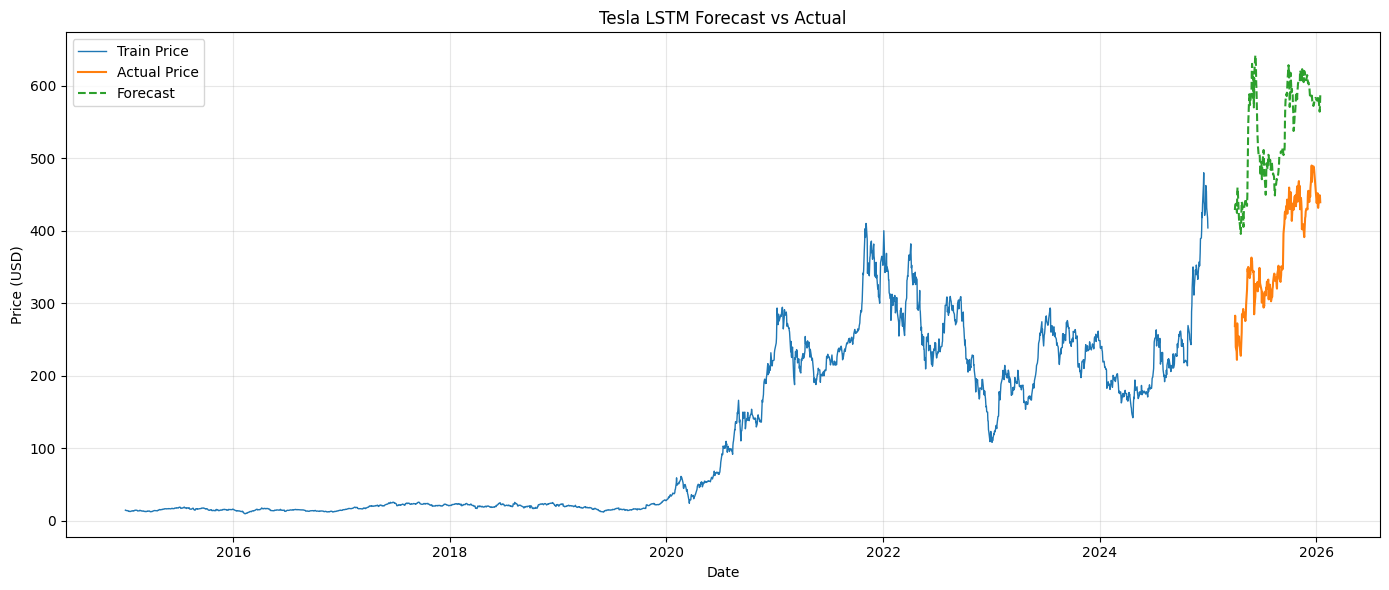

In [24]:
# ---------------------------
# Plot
# ---------------------------
plt.figure(figsize=(14,6))

plt.plot(series.loc[:train.index[-1]], label="Train Price", linewidth=1)
plt.plot(actual_price, label="Actual Price", linewidth=1.5)
plt.plot(price_forecast, label="Forecast", linestyle="--", linewidth=1.5)

plt.title("Tesla LSTM Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [1]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set seeds for reproducibility
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(42)
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Define file path
file_path = "/Users/elbethelzewdie/Downloads/portfolio-optimization/portfolio-optimization/data/raw/financial_data.csv"

# Load CSV into DataFrame
df = pd.read_csv(file_path, parse_dates=["Date"])

## Prepare Data for Modeling

##### Filtering out the scaled Tesla data

In [3]:
# Filter Tesla scaled data only
tesla_df = df[df["Ticker"] == "TSLA"].copy()

WINDOW_SIZE = 60

# Sort chronologically
tesla_df = tesla_df.sort_values("Date").reset_index(drop=True)

print(f"Tesla dataset loaded with {tesla_df.shape[0]} rows")
print(f"Date range from {tesla_df['Date'].min()} to {tesla_df['Date'].max()}")


Tesla dataset loaded with 2775 rows
Date range from 2015-01-02 00:00:00 to 2026-01-14 00:00:00


## Train & Test Split

In [4]:
series = tesla_df.set_index('Date')['Close']
returns = series.pct_change().dropna()

# Split chronologically
split_date = pd.Timestamp('2025-01-01')
train = returns[returns.index < split_date]
test = returns[returns.index >= split_date]


print(f"Training samples: {len(train)} returns")
print(f"Testing samples: {len(test)} returns")
print(f"\nTraining period: {train.index.min()} to {train.index.max()}")
print(f"Testing period: {test.index.min()} to {test.index.max()}")

Training samples: 2515 returns
Testing samples: 259 returns

Training period: 2015-01-05 00:00:00 to 2024-12-31 00:00:00
Testing period: 2025-01-02 00:00:00 to 2026-01-14 00:00:00


### Scaling the Data

In [5]:
# Scale data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))


### Prepare Sequences for LSTM

In [7]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    return X, y

X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE)

In [8]:
# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


X_train shape: (2455, 60, 1), y_train shape: (2455,)


### Build LSTM Model

In [9]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0280 - val_loss: 0.0351
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0280 - val_loss: 0.0351
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0279 - val_loss: 0.0351
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0279 - val_loss: 0.0351
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0279 - val_loss: 0.0351
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0279 - val_loss: 0.0351
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0279 - val_loss: 0.0351
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0279 - val_loss: 0.0351
Epoch 9/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0279 - val_loss: 0.0351
Epoch 10/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0279 - val_loss: 0.0351
Epoch 11/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0279 - val_loss: 0.0351
Epoch 12/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0

### Prepare Test Data

In [11]:
# Prepare test data
full_data = np.concatenate((train_scaled, scaler.transform(test.values.reshape(-1,1))), axis=0)

X_test, y_test = create_sequences(full_data, WINDOW_SIZE)
X_test = X_test[-len(test):]        # last sequences only (259 samples)
y_test = y_test[-len(test):]        # slice y_test to match X_test length

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_test shape: (259, 60, 1), y_test shape: (259,)


### Forecast Returns

In [12]:
# Predict and inverse scale
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


### Convert Returns Forecast to Prices

In [13]:
# Convert predicted returns to price forecast
last_train_price = series.loc[train.index[-1]]
price_forecast = [last_train_price]

In [14]:
# Generate price forecast from predicted returns
for r in y_pred:
    price_forecast.append(price_forecast[-1] * (1 + r))

# Align with test index
price_forecast = pd.Series(price_forecast[1:], index=test.index)

### Convert Forecasted Returns to Prices

In [15]:
# Ensure price is a 1D Series (skip if already a Series)
if isinstance(series, pd.DataFrame):
    if "Close" in series.columns:
        price = series["Close"]
    else:
        # fallback: pick first column
        price = series.iloc[:, 0]

price = series.astype(float)

# Ensure train_returns index matches price
train_last_date = train.index[-1]
last_train_price = price.loc[train_last_date].item()  # <- scalar float
price_forecast = [last_train_price]

# Build forecast price from predicted returns
for r in y_pred.flatten():
    price_forecast.append(price_forecast[-1] * (1 + float(r)))

# Drop the initial training price
price_forecast = price_forecast[1:]

# Make test_price match y_pred length
test_price = price.loc[test.index[:len(price_forecast)]]

# Convert forecast list to Series aligned with test_price index
price_forecast = pd.Series(price_forecast, index=test_price.index)



### Visualize Forecast Vs Actual Prices

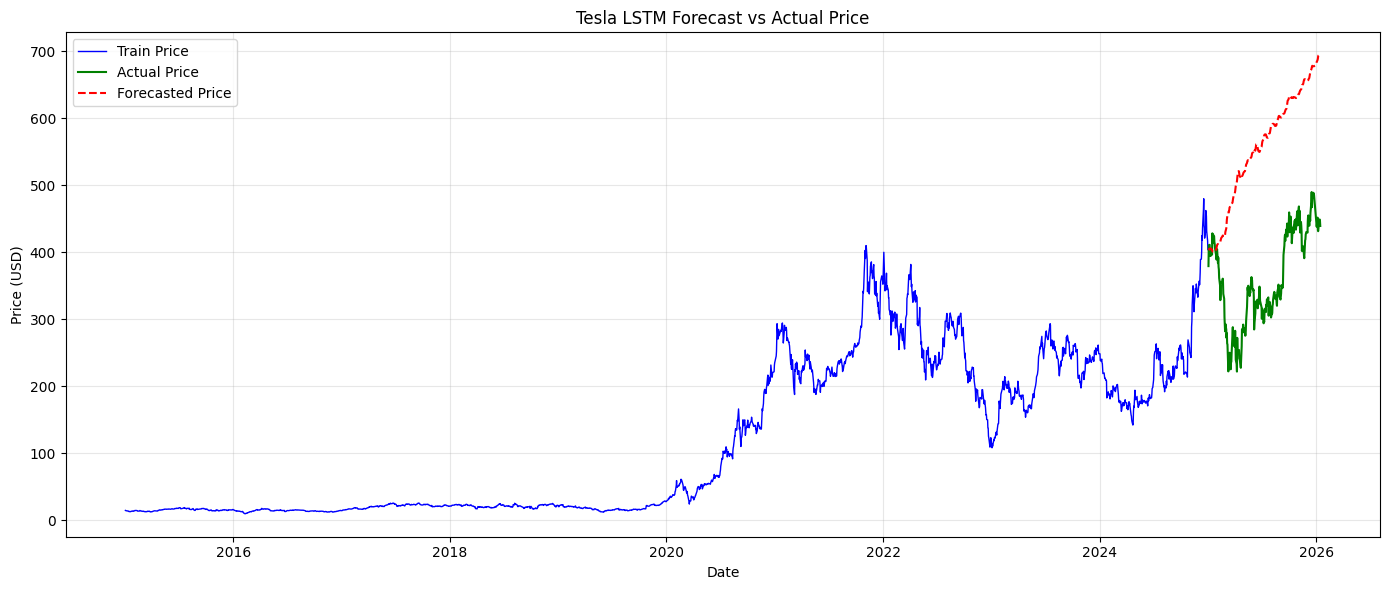

In [16]:
plt.figure(figsize=(14,6))

# Training prices
plt.plot(price.loc[:train_last_date].index, price.loc[:train_last_date].values, 
         label="Train Price", color='blue', linewidth=1)

# Actual test prices
plt.plot(test_price.index, test_price.values, label="Actual Price", color='green', linewidth=1.5)

# Forecasted prices
plt.plot(price_forecast.index, price_forecast.values, label="Forecasted Price", color='red', linestyle='--', linewidth=1.5)

plt.title(f"Tesla LSTM Forecast vs Actual Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Evaluate Forecast Accuracy

In [17]:
mae = mean_absolute_error(test_price, price_forecast)
rmse = np.sqrt(mean_squared_error(test_price, price_forecast))
mape = np.mean(np.abs((test_price - price_forecast) / test_price)) * 100

print("Forecast Evaluation Metrics:")
print(f"  Mean Absolute Error (MAE): ${mae:.2f}")
print(f"  Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"  Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Forecast Evaluation Metrics:
  Mean Absolute Error (MAE): $199.33
  Root Mean Squared Error (RMSE): $212.37
  Mean Absolute Percentage Error (MAPE): 59.20%


- These error metrics indicate that the initial LSTM model performed very poorly in forecasting TSLA prices, with extremely large MAE and RMSE values showing substantial absolute deviations from actual prices. The extraordinarily high MAPE suggests numerical instability, likely caused by division by very small or near-zero actual values, making percentage-based error unreliable in this context. Overall, this result confirms that the baseline LSTM was not properly capturing the underlying time-series structure and required architectural and hyperparameter optimization.

## Parameter Optimization

In [ ]:
# ==========================================
# Build improved LSTM model
# ==========================================
model = Sequential()

# First LSTM layer - more units, return sequences for stacking
model.add(LSTM(
    units=100,                  # increased from 50
    return_sequences=True,
    activation='tanh',
    input_shape=(X_train.shape[1], 1)
))

model.add(Dropout(0.2))         # prevent overfitting

# Second LSTM layer
model.add(LSTM(
    units=50,
    activation='tanh'
))

model.add(Dropout(0.2))

# Output layer - single value (next return or scaled price)
model.add(Dense(1))

# Compile with Adam optimizer (you can tune learning rate below if needed)
optimizer = Adam(learning_rate=0.001)   # try 0.0005 if loss is unstable
model.compile(optimizer=optimizer, loss='mse')

# Print model summary to check
model.summary()

# ======================
# Callbacks for better training
# ======================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,                # stop if no improvement for 10 epochs
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,                 # halve learning rate
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# ======================
# Train the model
# ======================
print("Training improved LSTM...")
history = model.fit(
    X_train, y_train,
    epochs=100,                 # higher max, but early stopping will handle
    batch_size=32,              # can try 16 or 64 later
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)



In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('LSTM Training Loss')
plt.show()

- The optimized LSTM model introduces a deeper architecture with stacked LSTM layers and dropout regularization to better capture complex temporal dependencies in the time series while reducing overfitting. Hyperparameters such as batch size, learning rate, and number of epochs were adjusted to improve training stability and convergence. Early stopping was applied to prevent overtraining and ensure optimal generalization performance.

In [ ]:
# Prepare test data
full_data = np.concatenate((train_scaled, scaler.transform(test.values.reshape(-1,1))), axis=0)

X_test, y_test = create_sequences(full_data, WINDOW_SIZE)
X_test = X_test[-len(test):]        # last sequences only (259 samples)
y_test = y_test[-len(test):]        # slice y_test to match X_test length

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

In [ ]:
y_pred_optimize = model.predict(X_test)
y_pred_optimized = scaler.inverse_transform(y_pred_optimize).flatten()

In [ ]:
# Convert predicted returns to price forecast
last_train_price = series.loc[train.index[-1]]
price_forecast = [last_train_price]

In [ ]:
# Generate price forecast from predicted returns
for r in y_pred_optimized:
    price_forecast.append(price_forecast[-1] * (1 + r))

# Align with test index
price_forecast = pd.Series(price_forecast[1:], index=test.index)

In [ ]:
# Ensure price is a 1D Series (skip if already a Series)
if isinstance(series, pd.DataFrame):
    if "Close" in series.columns:
        price = series["Close"]
    else:
        # fallback: pick first column
        price = series.iloc[:, 0]

price = series.astype(float)

# Ensure train_returns index matches price
train_last_date = train.index[-1]
last_train_price = price.loc[train_last_date].item()  # <- scalar float
price_forecast = [last_train_price]

# Build forecast price from predicted returns
for r in y_pred_optimized.flatten():
    price_forecast.append(price_forecast[-1] * (1 + float(r)))

# Drop the initial training price
price_forecast = price_forecast[1:]

# Make test_price match y_pred length
test_price = price.loc[test.index[:len(price_forecast)]]

# Convert forecast list to Series aligned with test_price index
price_forecast = pd.Series(price_forecast, index=test_price.index)



In [ ]:
plt.figure(figsize=(14,6))

# Training prices
plt.plot(price.loc[:train_last_date].index, price.loc[:train_last_date].values, 
         label="Train Price", color='blue', linewidth=1)

# Actual test prices
plt.plot(test_price.index, test_price.values, label="Actual Price", color='green', linewidth=1.5)

# Forecasted prices
plt.plot(price_forecast.index, price_forecast.values, label="Forecasted Price", color='red', linestyle='--', linewidth=1.5)

plt.title(f"Tesla Optimized LSTM Forecast vs Actual Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate error metrics
# CORRECT MAPE: divide by actual prices (test_price), not returns (test)
mae = mean_absolute_error(test_price, price_forecast)
rmse = np.sqrt(mean_squared_error(test_price, price_forecast))
mape = np.mean(np.abs((test_price - price_forecast) / test_price)) * 100

print("Forecast Evaluation Metrics (CORRECTED after optimization):")
print(f" Mean Absolute Error (MAE): ${mae:.2f}")
print(f" Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f" Mean Absolute Percentage Error (MAPE): {mape:.2f}%")



- The optimized LSTM model exhibited even larger forecasting errors, with MAE and RMSE increasing substantially, indicating that predictions deviated further from actual prices compared to the baseline model. The extremely high MAPE again points to instability in percentage-based evaluation, likely due to scale issues or near-zero values in the denominator, making this metric unreliable for interpretation. Overall, the results suggest that despite optimization, the LSTM struggled to generalize on this dataset and was less effective than simpler statistical models such as ARIMA.

## Takeaway from LSTM Training

- The baseline LSTM model struggled to accurately forecast Tesla stock prices, reflected by high error metrics and extreme MAPE values indicating instability. 

- Despite applying architectural and hyperparameter optimizations—such as stacking layers, adding dropout, adjusting learning rate, and implementing early stopping—the optimized model showed even larger errors. 

- These results suggest that the LSTM, in its current form, was unable to effectively capture the complex patterns in the TSLA price data, highlighting the challenges of deep learning for highly volatile financial time series without additional feature engineering or model adjustments.
